In [39]:
import numpy as np
import tqdm
import pandas as pd

In [40]:
train_df = pd.read_csv("data/short_train.csv")
test_df = pd.read_csv("data/short_test.csv")

In [41]:
train_df["t"] = train_df["t"].fillna(-1)
test_df["t"] = test_df["t"].fillna(-1) 

In [42]:
train_df['target'] = train_df['x1']

In [43]:
train_df.columns

Index(['ego_id', 'u', 'v', 't', 'x1', 'x2', 'x3', 'target'], dtype='object')

### Сымитируем реальную выборку, где нужно предсказывать в среднем 20% связей для графа. В каждом графе сделаем x1 целевой метрикой, но предиктить будем только этих 20% связей. Сделаем различные фичи для этих связей.

### Почему предиктим только 20%, а не все 100%? -Потому что в этом случае многие фичи будут содержать даталик. Соот-но, если мы будем вначале "выкидывать"(заменять на nan) x1, а потом только строить дополнительные фичи, то даталика не будет, а также бонусом получается имитация test, где фичи строятся с nan значениями в x1.


In [44]:
all_nan_indexes_list = []#np.array([])
for (graph_index, sub_df) in tqdm.tqdm(train_df.groupby('ego_id')):
    rows_amount = sub_df.shape[0]
    first_row_index = sub_df.index[0]
    
    nan_indexes = np.random.choice(rows_amount,int(0.2*rows_amount))+first_row_index 
    all_nan_indexes_list.append(nan_indexes)
    train_df.loc[nan_indexes,'target'] = np.nan


100%|██████████| 962/962 [00:00<00:00, 1718.60it/s]


In [45]:
all_nan_indexes_one_dim = []
for i in tqdm.tqdm(all_nan_indexes_list):
    for j in i:
        all_nan_indexes_one_dim.append(j)
#    all_nan_indexes = np.append(all_nan_indexes,np.array(i))

100%|██████████| 962/962 [00:00<00:00, 18499.73it/s]


In [46]:
all_nan_indexes = np.array(all_nan_indexes_one_dim)

In [47]:
train_dataset = train_df.iloc[all_nan_indexes].drop(columns=['target'])
test_dataset = test_df

train_dataset = train_dataset.reset_index().drop(columns=['index'])



### Объединим данные из attr.csv с нашим датасетом для того, чтобы можно было сделать больше различных признаков

In [48]:
attr = pd.read_csv('data/attr.csv')
attr_cols = attr.columns[2:]
attr['v'] = attr['u']
attr = attr[['ego_id']+['u']+['v']+list(attr_cols)]

In [49]:
attr.columns[3:]

Index(['age', 'city_id', 'sex', 'school', 'university'], dtype='object')

In [50]:
for col in tqdm.tqdm(attr.columns[3:]):
    train_dataset['u_'+col] = train_dataset.merge(attr.loc[:,['ego_id','u', col]], on = ['ego_id','u'], how = 'left')[col]
    train_dataset['v_'+col] = train_dataset.merge(attr.loc[:,['ego_id','v', col]], on = ['ego_id','v'], how = 'left')[col]
    

100%|██████████| 5/5 [00:46<00:00,  9.36s/it]


In [51]:
for col in tqdm.tqdm(attr.columns[3:]):
    test_dataset['u_'+col] = test_dataset.merge(attr.loc[:,['ego_id','u', col]], on = ['ego_id','u'], how = 'left')[col]
    test_dataset['v_'+col] = test_dataset.merge(attr.loc[:,['ego_id','v', col]], on = ['ego_id','v'], how = 'left')[col]
    

100%|██████████| 5/5 [00:48<00:00,  9.75s/it]


In [52]:
test_dataset.isna().sum()

ego_id               0
u                    0
v                    0
t                    0
x1              200006
x2                   0
x3                   0
u_age            67760
v_age            67772
u_city_id        67760
v_city_id        67772
u_sex            67760
v_sex            67772
u_school         67760
v_school         67772
u_university     67760
v_university     67772
dtype: int64

In [53]:
train_dataset = train_dataset.fillna(-1)

In [54]:
test_dataset_fillna_cols = ['u_age','v_age',   'u_city_id',        
'v_city_id',        
'u_sex'     ,       
'v_sex'      ,      
'u_school'    ,     
'v_school'     ,    
'u_university',     
'v_university'] 
test_dataset.loc[:,test_dataset_fillna_cols] = test_dataset.loc[:,test_dataset_fillna_cols].fillna(-1)

In [55]:
train_dataset['u_age'].isna().sum()

0

#### Разделим добавляемые фичи на локальные, глобальные и смешанные. Локальные признаки - признаки, полученные по информации с информации о ребре(строчке из датасета). Глобальные - информация о графе в целом. Смешанные - совмещает как информацию о ребре, так и информацию о графе.

### LOCAL FEATURES

In [56]:
train_dataset['isEqCity'] = (train_dataset['u_city_id'] ==train_dataset['v_city_id'] ).astype(np.int8)
train_dataset['isEqSex'] = (train_dataset['u_sex'] ==train_dataset['v_sex'] ).astype(np.int8)
train_dataset['isEqSchool'] = (train_dataset['u_school'] ==train_dataset['v_school'] ).astype(np.int8)
train_dataset['isEqSchool'] = (train_dataset['u_school'] ==train_dataset['v_school'] ).astype(np.int8)
train_dataset['isEqUni'] = (train_dataset['u_university'] ==train_dataset['v_university'] ).astype(np.int8)
train_dataset['abs_diff_age'] = np.abs(train_dataset['u_age'] -train_dataset['v_age'] ).astype(np.int8)


test_dataset['isEqCity'] = (test_dataset['u_city_id'] ==test_dataset['v_city_id'] ).astype(np.int8)
test_dataset['isEqSex'] = (test_dataset['u_sex'] ==test_dataset['v_sex'] ).astype(np.int8)
test_dataset['isEqSchool'] = (test_dataset['u_school'] ==test_dataset['v_school'] ).astype(np.int8)
test_dataset['isEqSchool'] = (test_dataset['u_school'] ==test_dataset['v_school'] ).astype(np.int8)
test_dataset['isEqUni'] = (test_dataset['u_university'] ==test_dataset['v_university'] ).astype(np.int8)
test_dataset['abs_diff_age'] = np.abs(test_dataset['u_age'] -test_dataset['v_age'] ).astype(np.int8)


In [57]:
train_dataset.columns

Index(['ego_id', 'u', 'v', 't', 'x1', 'x2', 'x3', 'u_age', 'v_age',
       'u_city_id', 'v_city_id', 'u_sex', 'v_sex', 'u_school', 'v_school',
       'u_university', 'v_university', 'isEqCity', 'isEqSex', 'isEqSchool',
       'isEqUni', 'abs_diff_age'],
      dtype='object')

In [58]:
test_dataset.shape,train_dataset.shape

((1000000, 22), (399617, 22))

In [59]:
train_dataset.head()

,ego_id,u,v,t,x1,x2,x3,u_age,v_age,u_city_id,...,v_sex,u_school,v_school,u_university,v_university,isEqCity,isEqSex,isEqSchool,isEqUni,abs_diff_age
0,0,151,0,45.8,0.004823,0.000000,1.0,36.0,43.0,237065842.0,...,1.0,541682015.0,-1.0,161530514.0,-1.0,1,1,0,0,7
1,0,209,199,40.4,0.414864,0.000000,0.0,22.0,21.0,237065842.0,...,1.0,75365905.0,-1.0,149014508.0,149014508.0,1,0,0,1,1
2,0,237,159,27.6,0.153904,0.000000,0.0,28.0,16.0,237065842.0,...,2.0,743047950.0,996782138.0,-1.0,193607289.0,1,1,0,0,12
3,0,167,127,86.0,1.328355,1.098612,1.0,22.0,21.0,237065842.0,...,1.0,605676195.0,-1.0,149014508.0,149014508.0,1,1,0,1,1
4,0,226,171,92.5,0.372068,0.000000,0.0,22.0,22.0,237065842.0,...,2.0,-1.0,109032968.0,815498626.0,149014508.0,1,1,0,0,0


### t>15 - is old friends. После t = 15 интенсивность близка к 0. Число 15 было получено методом локтя


In [60]:
train_dataset['isOldFriends'] = (train_dataset['t']>15).astype(np.int8)
test_dataset['isOldFriends'] = (test_dataset['t']>15).astype(np.int8)


### GLOBAL FEATURES

In [61]:

global_features_dict = {"ego_id":[],"nodes_amount":[],"connections_amount":[],"density":[],"mean_x1_global":[],"mean_x2_global":[],"mean_x3_global":[],"std_x1_global":[],"std_x2_global":[],"std_x3_global":[]}

for (graph_index,subtable) in train_df.groupby('ego_id'):
    global_features_dict["ego_id"].append(graph_index)
    global_features_dict["nodes_amount"].append(len(subtable['u'].unique()))
    global_features_dict["connections_amount"].append(len(subtable))
    global_features_dict["density"].append(len(subtable)/len(subtable['u'].unique()))
    global_features_dict["mean_x1_global"].append(subtable['x1'].mean())
    global_features_dict["mean_x2_global"].append(subtable['x2'].mean())
    global_features_dict["mean_x3_global"].append(subtable['x3'].mean())
    global_features_dict["std_x1_global"].append(subtable['x1'].std())
    global_features_dict["std_x2_global"].append(subtable['x2'].std())
    global_features_dict["std_x3_global"].append(subtable['x3'].std())

    
global_features_train = pd.DataFrame(global_features_dict)
    
    


In [62]:

global_features_dict = {"ego_id":[],"nodes_amount":[],"connections_amount":[],"density":[],"mean_x1_global":[],"mean_x2_global":[],"mean_x3_global":[],"std_x1_global":[],"std_x2_global":[],"std_x3_global":[]}

for (graph_index,subtable) in test_df.groupby('ego_id'):
    global_features_dict["ego_id"].append(graph_index)
    global_features_dict["nodes_amount"].append(len(subtable['u'].unique()))
    global_features_dict["connections_amount"].append(len(subtable))
    global_features_dict["density"].append(len(subtable)/len(subtable['u'].unique()))
    global_features_dict["mean_x1_global"].append(subtable['x1'].mean())
    global_features_dict["mean_x2_global"].append(subtable['x2'].mean())
    global_features_dict["mean_x3_global"].append(subtable['x3'].mean())
    global_features_dict["std_x1_global"].append(subtable['x1'].std())
    global_features_dict["std_x2_global"].append(subtable['x2'].std())
    global_features_dict["std_x3_global"].append(subtable['x3'].std())

    
global_features_test = pd.DataFrame(global_features_dict)
    
    


In [63]:
global_features_cols = list(global_features_dict.keys())
global_features_cols

['ego_id',
 'nodes_amount',
 'connections_amount',
 'density',
 'mean_x1_global',
 'mean_x2_global',
 'mean_x3_global',
 'std_x1_global',
 'std_x2_global',
 'std_x3_global']

In [64]:
train_dataset.merge(global_features_train.loc[:,global_features_cols], on = ['ego_id'], how = 'left')
test_dataset.merge(global_features_test.loc[:,global_features_cols], on = ['ego_id'], how = 'left')

,ego_id,u,v,t,x1,x2,x3,u_age,v_age,u_city_id,...,isOldFriends,nodes_amount,connections_amount,density,mean_x1_global,mean_x2_global,mean_x3_global,std_x1_global,std_x2_global,std_x3_global
0,8,20,19,185.7,3.839089e-04,0.0,0.0,37.0,37.0,979281502.0,...,1,173,1018,5.884393,0.436473,0.126365,0.084479,0.923410,0.575117,0.278242
1,8,131,125,161.4,4.034464e-01,0.0,0.0,35.0,38.0,-1.0,...,1,173,1018,5.884393,0.436473,0.126365,0.084479,0.923410,0.575117,0.278242
2,8,73,56,127.0,8.554643e-05,0.0,0.0,58.0,36.0,-1.0,...,1,173,1018,5.884393,0.436473,0.126365,0.084479,0.923410,0.575117,0.278242
3,8,0,4,594.5,2.886418e-01,0.0,0.0,36.0,37.0,979281502.0,...,1,173,1018,5.884393,0.436473,0.126365,0.084479,0.923410,0.575117,0.278242
4,8,63,73,127.0,4.281692e-07,0.0,0.0,39.0,58.0,979281502.0,...,1,173,1018,5.884393,0.436473,0.126365,0.084479,0.923410,0.575117,0.278242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,42949673174,51,87,-1.0,0.000000e+00,0.0,1.0,51.0,68.0,613782284.0,...,0,248,1945,7.842742,1.681008,0.199220,0.102314,2.025046,0.637638,0.303138
999996,42949673174,61,48,5.3,2.490737e+00,0.0,0.0,66.0,65.0,930240784.0,...,0,248,1945,7.842742,1.681008,0.199220,0.102314,2.025046,0.637638,0.303138
999997,42949673174,62,53,-1.0,2.349250e+00,0.0,0.0,66.0,55.0,255703164.0,...,0,248,1945,7.842742,1.681008,0.199220,0.102314,2.025046,0.637638,0.303138
999998,42949673174,31,156,8.2,NaN,0.0,0.0,18.0,53.0,528441128.0,...,0,248,1945,7.842742,1.681008,0.199220,0.102314,2.025046,0.637638,0.303138


In [65]:
train_dataset.columns

Index(['ego_id', 'u', 'v', 't', 'x1', 'x2', 'x3', 'u_age', 'v_age',
       'u_city_id', 'v_city_id', 'u_sex', 'v_sex', 'u_school', 'v_school',
       'u_university', 'v_university', 'isEqCity', 'isEqSex', 'isEqSchool',
       'isEqUni', 'abs_diff_age', 'isOldFriends'],
      dtype='object')

In [66]:
train_dataset.loc[train_dataset["u_city_id"]!=-1.0,"u_city_id"] = 0
train_dataset.loc[train_dataset["v_city_id"]!=-1.0,"v_city_id"] = 0


train_dataset.loc[train_dataset["u_school"]!=-1.0,"u_school"] = 0
train_dataset.loc[train_dataset["v_school"]!=-1.0,"v_school"] = 0

train_dataset.loc[train_dataset["u_university"]!=-1.0,"u_university"] = 0
train_dataset.loc[train_dataset["v_university"]!=-1.0,"v_university"] = 0


test_dataset.loc[test_dataset["u_city_id"]!=-1.0,"u_city_id"] = 0
test_dataset.loc[test_dataset["v_city_id"]!=-1.0,"v_city_id"] = 0


test_dataset.loc[test_dataset["u_school"]!=-1.0,"u_school"] = 0
test_dataset.loc[test_dataset["v_school"]!=-1.0,"v_school"] = 0

test_dataset.loc[test_dataset["u_university"]!=-1.0,"u_university"] = 0
test_dataset.loc[test_dataset["v_university"]!=-1.0,"v_university"] = 0



<AxesSubplot:>

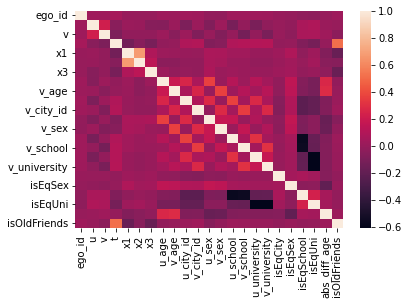

In [67]:
import seaborn as sns
sns.heatmap(train_dataset.corr())

In [68]:
# IOU, ADAMIC, COMMON FRIENDS, TOTAL FRIENDS
def make_graph_with_relationships(graph: pd.DataFrame) -> dict[int, int]:
    
    graph_with_rels = {}
    
    for index, row in graph.iterrows():
        
        if row['t'] != -1:
            v_friends = graph_with_rels.get(row['v'], set())
            v_friends.add(row['u'])
            graph_with_rels[row['v']] = v_friends
        
        else:
            pass
        
    return graph_with_rels

def get_easy_mixed_features(graph: pd.DataFrame) -> dict[str, float]:
    
    current_graph = make_graph_with_relationships(graph)
    
    mixed_features = {
        
        "friends_num_u": [],
        "friends_num_v": [],
        "common_friends": [],
        "iou": [],
        "adamic": [],
        "total_friends": []
    }
    
    
    for index, row in graph.iterrows():
        
        u_friends, v_friends = current_graph.get(row["u"], set()), current_graph.get(row["v"], set())
        common = u_friends.intersection(v_friends)
        union = u_friends.union(v_friends)
        
        mixed_features["friends_num_u"].append(len(u_friends))
        mixed_features["friends_num_v"].append(len(v_friends))
        mixed_features["common_friends"].append(len(common))

        if len(union) != 0:
            mixed_features["iou"].append(len(common) / len(union)) 
        else:
            mixed_features["iou"].append(0)
            
        mixed_features["adamic"].append(len(common) / np.log(len(current_graph.keys())))
        mixed_features["total_friends"].append(len(union))
    
    return mixed_features

In [69]:
mixed_info_cols = [ "friends_num_u",
        "friends_num_v",
        "common_friends",
        "iou",
        "adamic",
        "total_friends"]
for i in mixed_info_cols:
        train_dataset[i]= 0

In [70]:
for (ego_id, sub_df) in tqdm.tqdm(train_dataset.groupby('ego_id')):
    a = pd.DataFrame(get_easy_mixed_features(sub_df))
    a = a.set_index(sub_df.index)
    train_dataset.loc[sub_df.index,mixed_info_cols] = a
for (ego_id, sub_df) in tqdm.tqdm(test_dataset.groupby('ego_id')):
    a = pd.DataFrame(get_easy_mixed_features(sub_df))
    a = a.set_index(sub_df.index)
    test_dataset.loc[sub_df.index,mixed_info_cols] = a


100%|██████████| 506/506 [00:58<00:00,  8.67it/s]


In [71]:
train_dataset

,ego_id,u,v,t,x1,x2,x3,u_age,v_age,u_city_id,...,isEqSchool,isEqUni,abs_diff_age,isOldFriends,friends_num_u,friends_num_v,common_friends,iou,adamic,total_friends
0,0,151,0,45.8,0.004823,0.000000,1.0,36.0,43.0,0.0,...,0,0,7,1,0,30,0,0.0,0.000000,30
1,0,209,199,40.4,0.414864,0.000000,0.0,22.0,21.0,0.0,...,0,1,1,1,3,2,0,0.0,0.000000,5
2,0,237,159,27.6,0.153904,0.000000,0.0,28.0,16.0,0.0,...,0,0,12,1,2,1,0,0.0,0.000000,3
3,0,167,127,86.0,1.328355,1.098612,1.0,22.0,21.0,0.0,...,0,1,1,1,2,9,1,0.1,0.202656,10
4,0,226,171,92.5,0.372068,0.000000,0.0,22.0,22.0,0.0,...,0,0,0,1,2,3,0,0.0,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399612,25769803916,19,122,30.3,0.000000,0.000000,0.0,27.0,20.0,-1.0,...,0,1,7,1,1,1,0,0.0,0.000000,2
399613,25769803916,237,227,28.7,0.137694,0.000000,0.0,24.0,36.0,0.0,...,1,0,12,1,1,4,0,0.0,0.000000,5
399614,25769803916,118,166,29.0,0.032694,0.000000,0.0,40.0,37.0,0.0,...,0,1,3,1,0,7,0,0.0,0.000000,7
399615,25769803916,54,296,30.0,0.000510,0.000000,0.0,46.0,50.0,0.0,...,0,0,4,1,1,7,0,0.0,0.000000,8


<AxesSubplot:>

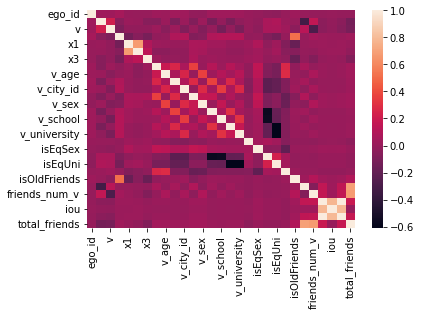

In [72]:
sns.heatmap(train_dataset.corr())

### Нормализуем данные

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

drop_cols = ['ego_id','u','v']

y = train_dataset['x1']
X = train_dataset.drop(columns=['x1']).drop(columns=drop_cols)




X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, shuffle=False, random_state=42)#shuffle = False, т.к граф представляется последовательно
sc.fit(X_train)
X_train = sc.transform(X_train)

X_val = sc.transform(X_val)



## После подготовки данных, подберем модель и обучим ее. 

### Данную задачу удалось свести к задаче классического  ML, поэтому в качестве моделей будут использоваться XGBoost и LightGBM, т.к эти модели хорошо показывают себя в решении задач классического ML, где присутствует большое разнообразие фич.

In [74]:
from sklearn.metrics import mean_squared_error

In [38]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(random_state = 42)
model.fit(X_train, y_train)
mean_squared_error(y_val, model.predict(X_val), squared=False)


0.7718718030272091

c:\Users\boris\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\basic.py:506: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


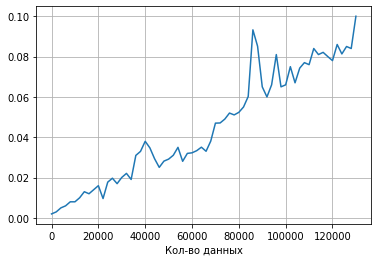

In [87]:
import time
import matplotlib.pyplot as plt
time_list = []
r = range(1,X_val.shape[0],2000)
for i in r:
    start = time.time()
    model.predict(X_val[:i])
    time_list.append(time.time()-start)
plt.plot(r, time_list)
plt.xlabel('Время, с')
plt.xlabel('Кол-во данных')
plt.grid()

plt.show()


### Submission

In [324]:
ego_id_u_v_columns = test_dataset[test_dataset['x1'].isna()]

test_df_nan_x1 = test_dataset.drop(columns=drop_cols)[test_dataset['x1'].isna()]
test_df_nan_x1_np = sc.transform( test_df_nan_x1.drop(columns = ['x1']))
test_df_nan_x1.loc[:,'x1'] = model.predict(test_df_nan_x1_np)

In [334]:
ego_id_u_v_columns.loc[:,'x1']=test_df_nan_x1.loc[:,'x1']
subm = ego_id_u_v_columns.loc[:,['ego_id','u','v','x1']]

subm.loc[subm['x1']<0,'x1'] = 0


C:\Users\boris\AppData\Local\Temp\ipykernel_2980\887882834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ego_id_u_v_columns.loc[:,'x1']=test_df_nan_x1.loc[:,'x1']


In [331]:
subm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200006 entries, 9 to 999999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ego_id  200006 non-null  int64  
 1   u       200006 non-null  int64  
 2   v       200006 non-null  int64  
 3   x1      200006 non-null  float32
dtypes: float32(1), int64(3)
memory usage: 6.9 MB


In [337]:

subm

,ego_id,u,v,x1
9,8,109,154,0.000000
10,8,51,30,0.042314
20,8,54,56,0.025092
26,8,106,9,0.000000
28,8,135,119,0.000000
...,...,...,...,...
999984,42949673174,43,98,0.240425
999989,42949673174,102,94,1.020106
999990,42949673174,149,0,0.422202
999998,42949673174,31,156,1.253917


In [340]:
th = pd.read_csv('data/submission.csv')



In [341]:
th

,ego_id,u,v,x1
0,8,0,93,0.000000
1,8,0,143,0.000000
2,8,0,151,1.606742
3,8,1,24,0.026496
4,8,5,4,0.159857
...,...,...,...,...
810971,1709396984676,73,23,1.562170
810972,1709396984676,74,68,0.454210
810973,1709396984676,77,28,0.078504
810974,1709396984676,79,38,0.981812


In [342]:
subm_map = {}
for i, row in tqdm.tqdm(subm.iterrows()):
    subm_map[(row["ego_id"], row["u"], row["v"])] = row["x1"]


200006it [00:05, 35488.22it/s]


In [343]:
res = []
for i, row in tqdm.tqdm(th.iterrows()):
    if (row["ego_id"], row["u"], row["v"]) in subm_map.keys():
         res.append([row["ego_id"], row["u"], row["v"], subm_map[(row["ego_id"], row["u"], row["v"])]])



810976it [00:21, 37080.18it/s]


In [345]:
final_subm = pd.DataFrame(np.array(res),columns=['ego_id','u','v','x1'])
final_subm['ego_id'] =final_subm['ego_id'].astype(np.int64)
final_subm['u'] =final_subm['u'].astype(np.int64)
final_subm['v'] =final_subm['v'].astype(np.int64)
final_subm.to_csv("final_subm.csv",index=False)


In [346]:
final_subm

,ego_id,u,v,x1
0,8,0,93,0.057666
1,8,0,143,0.909658
2,8,0,151,4.567711
3,8,1,24,0.087706
4,8,5,4,0.542361
...,...,...,...,...
20007,42949673174,157,175,1.328830
20008,42949673174,185,176,0.246712
20009,42949673174,197,196,0.852768
20010,42949673174,203,105,0.521382
